In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functools
import math
from scipy.stats import kendalltau

In [10]:
import networkx as nx
import random


# SI模型的传播参数
def SI_model(G, initial_infected, infection_probability, max_steps=20):

    infected_count = [len(initial_infected)]  # 用来记录每个时间步感染节点的数量
    infected_nodes = set(initial_infected)  # 初始感染者
    susceptible_nodes = set(G.nodes) - infected_nodes  # 易感节点
    
    # 模拟传播过程
    for t in range(max_steps):
        newly_infected = set()
        
        # 遍历每个感染节点，并尝试传染其未感染的邻居
        for node in infected_nodes:
            uninfected_nodes = susceptible_nodes & set(G.neighbors(node))  # 获取邻居节点中的未感染节点
            for uninfected in uninfected_nodes:
                if random.random() < infection_probability:
                    newly_infected.add(uninfected)
            susceptible_nodes -= newly_infected  # 更新易感节点
            
        # 更新感染节点集
        infected_nodes.update(newly_infected)
        num_infected = len(G.nodes()) - len(susceptible_nodes)
        infected_count.append(num_infected)  # 更新被感染节点数量
 
    return infected_count

In [40]:
@functools.lru_cache(maxsize=None)  # 没有缓存限制
def all_kshell_values(graph: nx.Graph) -> dict['Node' : 'k_shell_value']:
    
    return nx.core_number(graph)
    

@functools.lru_cache(maxsize=None)  # 没有缓存限制
def nodes_degree(graph) -> dict['Node' : 'degree']:
    
    return dict(graph.degree())
    

@functools.lru_cache(maxsize=None)  # 没有缓存限制
def max_kshell(graph) -> int:
    
    return max(all_kshell_values(graph).values())
    

@functools.lru_cache(maxsize=None)  # 没有缓存限制
def min_kshell(graph) -> int:
    
    return min(all_kshell_values(graph).values())
    

@functools.lru_cache(maxsize=None)  # 没有缓存限制
def source_node_shortest_path(graph, source) -> dict['Node' : 'distance']:
    '''
    计算源节点节点source到其他节点的最短路径，包括源节点本身
    返回值为dict[source node to target node, distance]
    '''
    
    return nx.shortest_path_length(graph, source)
    

def clear_all_cache():
    all_kshell_values.cache_clear()
    nodes_degree.cache_clear()
    max_kshell.cache_clear()
    min_kshell.cache_clear()
    source_node_shortest_path.cache_clear()
    normalized_comm_network_matrix.cache_clear()

In [26]:
def gravity_centrality(graph, node) -> float:
    '''
    采用k_shell值作为质量，最短路径作为距离，截断半径根据网络特性自己设置，一般为网络直径的一半
    计算节点node的重力中心性。

    graph->所要计算的图
    node->所要计算重力中心性的节点
    所有节点的k_shell值，可用nx.core_number(graph)函数计算。返回值为dic{node : value}
    influence_radius->节点node的影响半径.
    '''
    
    influence_radius = 2
    gravity_centrality = 0
    neighbors = set()
    path_lengths = source_node_shortest_path(graph, node)  # 存储源节点node到其它节点的最短距离
    k_shell = all_kshell_values(graph)
    
    for neighbor in graph.neighbors(node):     
        if path_lengths[neighbor] <= influence_radius:
            neighbors.add(neighbor)
            
    for neighbor in neighbors:
        num = k_shell[node] * k_shell[neighbor]
        distance = path_lengths[neighbor]
        gravity_centrality += num / (distance ** 2)

    return gravity_centrality

def all_gravity_centrality(G):
    '''
    循环调用gravity_centrality计算所有节点重力中心性
    GC返回值为dic{nod : value of gravity centrality}
    '''
    
    GC = {node : 0 for node in G.nodes()}
    for node in G.nodes():
        GC[node] = gravity_centrality(G, node)
        source_node_shortest_path.cache_clear()  # 清空已处理过节点的最短路径缓存

    clear_all_cache()

    return GC

In [43]:
# 创建一个随机图
n_nodes = 200  # 指定节点数
p = 0.05  # 每条边存在的概率
G = nx.gnp_random_graph(n_nodes, p)

In [29]:

# 计算各中心性值
DC = nx.degree_centrality(G)
CC = nx.closeness_centrality(G)
BC = nx.betweenness_centrality(G)
GC = all_gravity_centrality(G)

# 获取中心性排序
sorted_DC = dict(sorted(DC.items(), key=lambda item: item[1], reverse=True))
sorted_CC = dict(sorted(CC.items(), key=lambda item: item[1], reverse=True))
sorted_BC = dict(sorted(BC.items(), key=lambda item: item[1], reverse=True))
sorted_GC = dict(sorted(GC.items(), key=lambda item: item[1], reverse=True))

# 选择前20名节点
DC_top_20 = list(sorted_DC.keys())[:20]
CC_top_20 = list(sorted_CC.keys())[:20]
BC_top_20 = list(sorted_BC.keys())[:20]
GC_top_20 = list(sorted_GC.keys())[:20]


In [34]:
# 获取前20名节点np.array数组
DC_top_20_array = np.array(DC_top_20)
CC_top_20_array = np.array(CC_top_20)
BC_top_20_array = np.array(BC_top_20)
GC_top_20_array = np.array(GC_top_20)
sorted_matrix = np.column_stack((DC_top_20_array, CC_top_20_array, BC_top_20_array, GC_top_20_array))
print(sorted_matrix)

[[ 63  63  63  63]
 [168 168 168 168]
 [ 19  19 167  19]
 [ 78 118 172  78]
 [ 81 155  81  81]
 [167  81 169 167]
 [169 167  19 169]
 [118  78 155 164]
 [155  20 118 118]
 [164 172 187 155]
 [172 187  78 172]
 [ 24  52 162  24]
 [162 169 164 162]
 [ 20 142  24  20]
 [ 51  56 149  76]
 [ 76  76 142  51]
 [142 162  51 146]
 [146 164 102 142]
 [149 102 147  52]
 [187   2 146 187]]


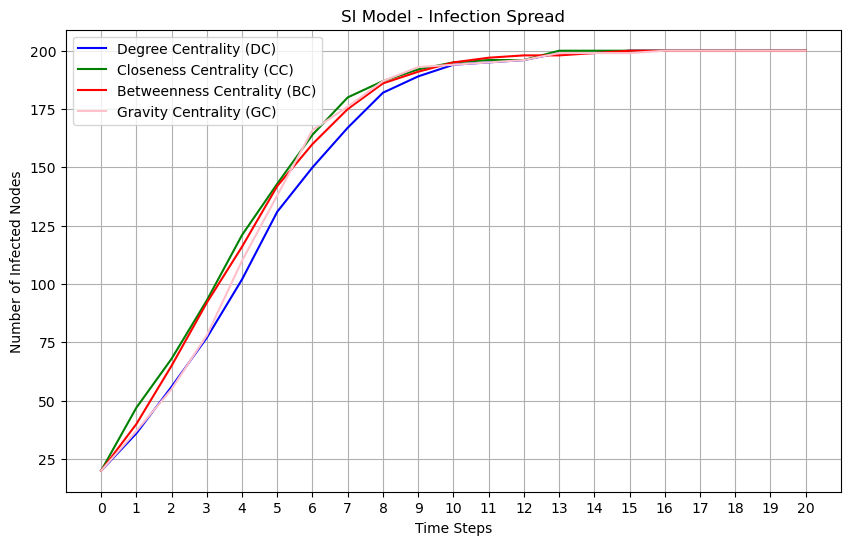

In [33]:
# SI模型模拟
infection_probability = 0.07
infected_DC = SI_model(G, DC_top_20, infection_probability)
infected_CC = SI_model(G, CC_top_20, infection_probability)
infected_BC = SI_model(G, BC_top_20, infection_probability)
infected_GC = SI_model(G, GC_top_20, infection_probability)


# 画出传播过程中的感染者数量变化
plt.figure(figsize=(10, 6))
plt.plot(infected_DC, label='Degree Centrality (DC)', color='blue')
plt.plot(infected_CC, label='Closeness Centrality (CC)', color='green')
plt.plot(infected_BC, label='Betweenness Centrality (BC)', color='red')
plt.plot(infected_GC, label='Gravity Centrality (GC)', color='pink')
# 设置横坐标为0到20，步长为1
plt.xticks(range(21))

plt.xlabel('Time Steps')
plt.ylabel('Number of Infected Nodes')
plt.title('SI Model - Infection Spread')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [4]:
def grav_coeff(graph: nx.Graph, i: 'Node', j: 'Node') -> float:
    '''
    计算节点i和节点j之间的重力系数
    节点i为所要计算的节点重力中心性
    '''
    k_shell = all_kshell_values(graph)
    denom = max_kshell(graph) - min_kshell(graph)
    denom = 1 if denom == 0 else denom

    # 它可以接受两个参数，第一个是底数（base），第二个是指数（exponent）
    g = np.power(np.e, (k_shell[i] - k_shell[j]) / denom)
    return g

In [5]:
def gravitational_force(graph, i, j) -> float:
    '''
    改进的万有引力公式，采用度值作为质量进行计算
    并为每个节点对设置引力系数g，节点对的g由函数
    grav_coeff()计算。

    source_node_shortest_path|dic{node : distance}存储源节点source到其他节点的最短路径长度
    包括节点i到节点i本身的路径长度
    '''
    target_degree = nodes_degree(graph)
    degree_prod = target_degree[i] * target_degree[j]
    path_length = source_node_shortest_path(graph, i)

    # 节点i到节点j的最短距离
    distance = path_length[j]
    distance = 1 if distance == 0 else distance

    g = grav_coeff(graph, i, j)

    return g * degree_prod / np.square(distance)

In [29]:
def balance_node(graph: nx.Graph, i: 'Node', delta: float) -> list:
    '''
    计算节点i不同delta对应的平衡节点s，s可能由多个值因此用列表存储
    平衡节点是说达到力平衡的节点。
    
    通过平衡节点计算节点i的影响半径
    '''
    
    k_shell = all_kshell_values(graph)  # 获取所有节点的k_shell值
    denom = max_kshell(graph) - min_kshell(graph)
    denom = 1 if denom == 0 else denom
    delta = delta ** 2


    exponent = np.log(delta)  #计算delta所对应的指数
    s_k_shell = int(exponent * denom + k_shell[i])
    balence_nodes = []
    for node, k_value in k_shell.items():
        if k_value == s_k_shell:
            balence_nodes.append(node)

    return balence_nodes

In [39]:
def radius_of_influence(graph: nx.Graph, i: 'Node', delta: float) -> float | int:
    balence_nodes_s = balance_node(graph, i, delta)  # 计算delta下节点i的平衡节点
    s_distance = {}  # 键为平衡节点s，值为节点i到s的最短距离，如果没有路径则距离为0
    s_degree = {}  # dict{balence node s : degree of s node}

    # 计算源节点i到其他节点的最短路径
    i_shortest_path = source_node_shortest_path(graph, i)
    node_degree = nodes_degree(graph)

    for balence_node in balence_nodes_s:
        s_degree[balence_node] = node_degree[balence_node]
        if balence_node in i_shortest_path.keys():
            s_distance[balence_node] = i_shortest_path[balence_node]
            
    num_balence_node = len(balence_nodes_s)  # 存储平衡节点的数量
    if num_balence_node == 0:
        num_balence_node = 1
        
    s_average_degree = sum(s_degree.values()) / num_balence_node  # 计算平衡节点集的平均度
    s_average_distance = sum(s_distance.values()) / num_balence_node  # 计算节点i到平衡节点集的平均距离
    if node_degree[i] == 0:
        degree_quotient = np.abs(s_average_degree)  # abs开根号
    else:
        degree_quotient = np.abs(s_average_degree / node_degree[i])  # abs开根号

    # 计算节点i的截断半径
    i_radius = s_average_distance / (1 + (np.sqrt(degree_quotient) * delta))
    if i_radius == 0:
        i_radius = 1

    return i_radius


In [48]:
radius = {}
for node in G.nodes():
    radius[node] = radius_of_influence(G, node, 0.8)
print(radius)

{0: 1.7667073853152262, 1: 1.6043221452637098, 2: 1.8920998001844527, 3: 1.6757190582305446, 4: 1.6668498239720178, 5: 1.7267316464601141, 6: 1.8108750699481067, 7: 1.8488980527016066, 8: 2.0209745628529836, 9: 1, 10: 1.624601960612383, 11: 2.4696276922520344, 12: 1.7933210450711254, 13: 1.9348990223135827, 14: 1.6835633552986111, 15: 1.693687776840512, 16: 1.9160937134592437, 17: 1.8793487987374884, 18: 1.8550427545809876, 19: 1.4497459896284517, 20: 1.8877063632327638, 21: 1.7569498144569917, 22: 1.935643173532014, 23: 2.297005522465285, 24: 1.8994048111061255, 25: 1.7225397006823453, 26: 1.9857413934291313, 27: 1.769899937621617, 28: 1.8108750699481067, 29: 1.8470498049419657, 30: 1.2773958089728292, 31: 1.693687776840512, 32: 1.8694580420923346, 33: 1.8562365199446227, 34: 1.6668498239720178, 35: 1.81306822878312, 36: 1.7569498144569917, 37: 1.8793487987374884, 38: 1.7933210450711254, 39: 1.6668498239720178, 40: 1.836344920196039, 41: 1.7222668098480596, 42: 1.604550408747849, 43: 

In [45]:
def diameter_network(graph: nx.Graph) -> int:
    if nx.is_connected(graph):
        
        # 计算并打印网络的直径
        diameter = nx.diameter(graph)
    else:
        
        # 获取最大连通子图
        largest_component = max(nx.connected_components(graph), key=len)  # 最大连通子图的节点集合
        subgraph = graph.subgraph(largest_component)
        # 计算最大连通子图的直径
        diameter = nx.diameter(subgraph)
    
    return diameter

In [47]:
a = diameter_network(G)
print(a)

4


In [35]:
def comm_network_matrix(graph: nx.Graph) -> list[list[float]]:
    '''
    计算通信概率矩阵X
    '''

    A = nx.to_numpy_array(graph)  # 图graph的邻接矩阵

    diam = diameter_network(graph)  # 图的网络直径
    
    # 初始化通信概率矩阵 X
    X = np.zeros_like(A, dtype=np.float32)
    for n in range(1, diam + 1):
        A_n_power = np.linalg.matrix_power(A, n)  # 计算 A 的 n 次方
        
        X += (1 / math.factorial(n)) * A_n_power

    return np.real(X)

In [36]:
@functools.lru_cache(maxsize=None) 
def normalized_comm_network_matrix(graph: nx.Graph) -> list[list[float]]:
    X = comm_network_matrix(graph)

    X_max = np.max(X)
    X_min = np.min(X)

    '''
    (X - X_min),X_min是一个具体的数字，该操作会自动执行numpy的广播机制.
    将不同维度的两个数据进行数学运算时，将较小维度数据广播为与另一个数据维度大小相同的数据。
    其中X_min中的每个元素都是X_min
    '''

    return (X - X_min) / (X_max - X_min)

In [24]:
@functools.lru_cache(maxsize=None)
def node_to_index(graph: nx.Graph) -> dict[int, int]:
    return {node: i for i, node in enumerate(graph.nodes())}

In [34]:
def neighbors_node_underneath_radius(graph: nx.Graph, i: 'node', radius: int) -> list:
    neighbors = []

    # 存储源节点i到其它节点的最短距离,除到源节点距离为0之外，无路径的节点对不会返回键值对。如{2: 0, 7: 1}
    i_shortest_path = source_node_shortest_path(graph, i)
    
    for node in i_shortest_path.keys():     
        if (node != i) & (i_shortest_path[node] <= radius):
            neighbors.append(node)

    # 孤立节点的neighbors为空列表
    return neighbors

In [49]:
def cagm_float(graph: nx.Graph, i: 'Node', delta: float) -> float:
    # delta为浮点数时计算节点i的cagm值
    
    radius = radius_of_influence(graph, i, delta)
    integer_radius = int(np.floor(radius))
    fractional_radius = radius - integer_radius
    cagm_value_floor = 1
    cagm_value_ceil = 1
    node_to_idx = node_to_index(graph)

    # Sum influence for neighbors within integer radius
    i_shortest_path = source_node_shortest_path(graph, i)
    # 获取距离小于integer_radius的节点
    neighbors = neighbors_node_underneath_radius(graph, i, integer_radius)
    norm_comm_matrix = normalized_comm_network_matrix(graph)  # 计算标准化通信概率矩阵
    for y in neighbors:
        if y != i:
            i_idx = node_to_idx[i]
            y_idx = node_to_idx[y]
            influence_probability = norm_comm_matrix[i_idx][y_idx]

            force = gravitational_force(graph, i, y)
            cagm_value_floor += influence_probability * force
    

    # Add fractional influence for neighbors at ⌈R_i⌉
    fractional_neighbors = [node for node, path_length in i_shortest_path.items() if path_length == integer_radius + 1]
    for w in fractional_neighbors:
        if w != i:
            i_idx = node_to_idx[i]
            w_idx = node_to_idx[w]
            influence_probability = norm_comm_matrix[i_idx][w_idx]

            force = gravitational_force(graph, i, w)
            cagm_value_ceil += influence_probability * force
    cagm_value_ceil = fractional_radius * cagm_value_ceil

    return cagm_value_floor + cagm_value_ceil

def cagm_int(graph: nx.Graph, i: 'Node', delta) -> float:
    # delta为整数数时计算节点i的cagm值
    
    radius = radius_of_influence(graph, i, delta)
    radius = int(np.floor(radius))
    cagm_value = 0
    node_to_idx = node_to_index(graph)
    
    i_shortest_path = source_node_shortest_path(graph, i)
    # 获取距离小于integer_radius的节点
    neighbors = neighbors_node_underneath_delta(graph, i, delta)
    norm_comm_matrix = normalized_comm_network_matrix(graph)  # 计算标准化通信概率矩阵
    
    for y in neighbors:
        if y != i:
            i_idx = node_to_idx[i]
            y_idx = node_to_idx[y]
            influence_probability = norm_comm_matrix[i_idx][y_idx]

            force = gravitational_force(graph, i, y)
            cagm_value += influence_probability * force

    return cagm_value

In [41]:
def cagm_centrality(graph: nx.Graph, delta: float) ->dict:

    cagm_values = {}  # 初始化每个节点的cagm值

    for i in node_to_index(graph).keys():
        i_radius = radius_of_influence(graph, i, delta)  # 节点i的影响半径
        if i_radius % 1 == 0:
            cagm_values[i] = cagm_int(graph, i, delta)
        else:
            cagm_values[i] = cagm_float(graph, i, delta)

    return cagm_values

In [46]:
cagm = cagm_centrality(G, 0.8)
print(cagm)

{0: 417.40020060211407, 1: 473.3670112800539, 2: 496.3081014637256, 3: 435.51461533968336, 4: 330.08854555918174, 5: 225.90994867038063, 6: 325.8886663416242, 7: 234.15561562959056, 8: 2286.2785011307164, 9: 12.718033876611099, 10: 1078.2834030723675, 11: 51.38427164614478, 12: 806.2558786774947, 13: 779.5910440567001, 14: 289.7797833774222, 15: 140.7809219603808, 16: 159.13723713513917, 17: 467.2411732497442, 18: 351.65529933822165, 19: 1259.649536163424, 20: 807.6676068413067, 21: 372.58048244317183, 22: 137.16271964115236, 23: 122.51614793229768, 24: 218.6063287796877, 25: 377.673835769687, 26: 354.79014972552886, 27: 232.44729002553612, 28: 389.94057045753846, 29: 409.0525640874607, 30: 44.280267159483856, 31: 98.4175838695267, 32: 150.15506378510918, 33: 220.06381917537476, 34: 467.4169066694775, 35: 313.71954617711003, 36: 440.22077697845725, 37: 672.7668549687291, 38: 886.9418237127164, 39: 515.776139725539, 40: 1220.2334133979653, 41: 777.726107505691, 42: 816.4479390968413, 43

In [39]:
def evaluate(graph: nx.Graph):
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    pagerank_centrality = nx.pagerank(graph)

    eval_df = pd.DataFrame({"Degree Centrality" :degree_centrality, "Betweenness Centrality": betweenness_centrality, "PageRank Centrality": pagerank_centrality})

    return eval_df


node_influence = evaluate(graph)